In [29]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [30]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [31]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Figure description


#### 5 subplots of model results vs observations for hindcast 201905 (only values where model>1800 are shown)
#### a table of model statistics, both for full dataset and for 


In [32]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seawater
import netCDF4 as nc



#### LOAD OBSERVATIONAL DATA

In [33]:
infil = np.loadtxt('./Datasets/grl2016_nu.txt')
P = infil[:,8]
T = infil[:,9]
S = infil[:,10]
dic = infil[:,13]
alk = infil[:,15]
dens = seawater.dens(S,T,P)
# CONVERT FROM UMOL TO MMOL/M3
ta_conv=alk*dens/1000
dic_conv=dic*dens/1000
S_rs = S * 35.16504/35

#### CALCULATE EVALUATION STATISTICS FOR YEARS 2013-2017

In [34]:
sal_WSS = np.zeros(5)
sal_RMSE = np.zeros(5)
sal_bias = np.zeros(5)
sal_modstd = np.zeros(5)
sal_obsstd = np.zeros(5)

sal_WSS_over1800 = np.zeros(5)
sal_RMSE_over1800 = np.zeros(5)
sal_bias_over1800 = np.zeros(5)
sal_modstd_over1800 = np.zeros(5)
sal_obsstd_over1800 = np.zeros(5)

for yr in range(2013,2018):
    index = yr - 2013

    scrdir = './MODEL_EVAL_scripts/'
    DIC = nc.Dataset(scrdir+'/DIC_hindcast201905_GRL_comp_' + str(yr) + '.nc')
    sal = nc.Dataset(scrdir+'/sal_hindcast201905_GRL_comp_' + str(yr) + '.nc')

    #extractions
    DIC_mod = DIC['model_output']['mod_point'][:]
    DIC_mod[DIC_mod==0]=np.nan
    dic_compbl = dic_conv[~(np.isnan(DIC_mod))&(~np.isnan(dic_conv))]
    DIC_mod_compbl = DIC_mod[~(np.isnan(DIC_mod))&(~np.isnan(dic_conv))]

    sal_mod = sal['model_output']['mod_point'][:]
    sal_mod[sal_mod==0]=np.nan
    sal_compbl = S_rs[~(np.isnan(DIC_mod))&(~np.isnan(dic_conv))]
    sal_mod_compbl = sal_mod[~(np.isnan(DIC_mod))&(~np.isnan(dic_conv))]
    
    
    obs =sal_compbl
    mod = sal_mod_compbl
    xbar = np.mean(obs)
  
    sal_bias[index] = (-np.mean(obs) + np.mean(mod))
    sal_RMSE[index] = (np.sqrt(np.sum((mod - obs)**2) /len(obs)))
    sal_WSS[index] = (1-(np.sum((mod - obs)**2)  / np.sum((np.abs(mod - xbar) + np.abs(obs - xbar))**2)))
    sal_modstd[index] = np.std(mod)
    sal_obsstd[index] = np.std(obs)
    

    obs =sal_compbl[dic_compbl>1800]
    mod = sal_mod_compbl[dic_compbl>1800]
    xbar = np.mean(obs)

    sal_bias_over1800[index] = (-np.mean(obs) + np.mean(mod))
    sal_RMSE_over1800[index] = (np.sqrt(np.sum((mod - obs)**2) /len(obs)))
    sal_WSS_over1800[index] = (1-(np.sum((mod - obs)**2)  / np.sum((np.abs(mod - xbar) + np.abs(obs - xbar))**2)))
    sal_modstd_over1800[index] = np.std(mod)
    sal_obsstd_over1800[index] = np.std(obs)
    


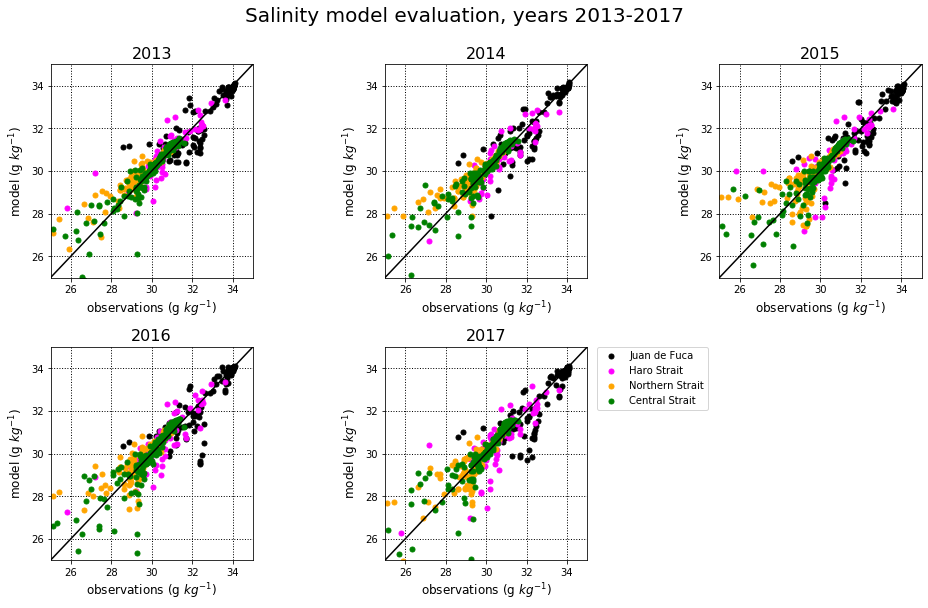

In [35]:
fig = plt.figure(figsize=(13,8))
fs = 12

for yr in range(2013,2018):
    i = yr - 2012
    scrdir = './MODEL_EVAL_scripts/'
    sal = nc.Dataset(scrdir+'/sal_hindcast201905_GRL_comp_' + str(yr) + '.nc')

    #extractions

    sal_mod = sal['model_output']['mod_point'][:]
    is_ref = sal['model_output']['mod_x'][:]
    js_ref = sal['model_output']['mod_y'][:]


    #locations 
    loc_tag = np.zeros_like(sal_mod)
    loc_tag[:] = 4

    for w in range(0,len(loc_tag)):
        x = is_ref[w]
        y = js_ref[w]
        #jdf is 1
        if  (x <200) & (y>220) & (y<500) :
            loc_tag[w] = 1
            #n strait
        if  (y >= 550):
            loc_tag[w] = 2
            #central strait
        if (x> 150) & (y>380) & (y<550):
            loc_tag[w] = 3
            #4 is haro/puget
        if ((x>150) & (y>320) & (y<370)):
            loc_tag[w] =4

    sal_mod[sal_mod==0]=np.nan

    #TA
    sal_jdf=S_rs[~(np.isnan(sal_mod))&(loc_tag==1)]
    sal_haro=S_rs[~(np.isnan(sal_mod))&(loc_tag==4)]
    sal_ns =S_rs[~(np.isnan(sal_mod))&(loc_tag==2)]
    sal_cs=S_rs[~(np.isnan(sal_mod))&(loc_tag==3)]

    sal_MODjdf=sal_mod[~(np.isnan(sal_mod))&(loc_tag==1)]
    sal_MODharo=sal_mod[~(np.isnan(sal_mod))&(loc_tag==4)]
    sal_MODns =sal_mod[~(np.isnan(sal_mod))&(loc_tag==2)]
    sal_MODcs=sal_mod[~(np.isnan(sal_mod))&(loc_tag==3)]

    sal_compbl = S_rs[~(np.isnan(sal_mod))]
    sal_mod_compbl = sal_mod[~(np.isnan(sal_mod))]

    #plot

    ax = fig.add_subplot(2,3,i)
    ax.grid(color='k', linestyle=':', linewidth=1)
    ax.plot(sal_jdf,sal_MODjdf,'ko',markersize=5, label = 'Juan de Fuca')
    ax.plot(sal_haro,sal_MODharo,c='fuchsia', marker='o',linestyle='None',markersize=5, label = 'Haro Strait')
    ax.plot(sal_ns,sal_MODns,c='orange', marker='o',linestyle='None',markersize=5, label = 'Northern Strait')
    ax.plot(sal_cs,sal_MODcs,c='green', marker='o',linestyle='None',markersize=5, label = 'Central Strait')

    ax.set_xlabel('observations (g $kg^{-1}$)', fontsize = fs)
    ax.set_ylabel('model (g $kg^{-1}$)', fontsize = fs)
    ax.set_title('year' + str(yr))
    #ax.legend( ['Juan de Fuca','Haro Strait','Northern Strait','Central Strait'],loc='best', fontsize = 20)
    if yr == 2017:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_xlim(25,35)
    ax.set_ylim(25,35)
    ax.plot([25,35],[25,35],'k')

    plt.title(str(yr), fontsize = 16)
    
plt.suptitle('Salinity model evaluation, years 2013-2017', y = 1.05, fontsize = 20)

plt.tight_layout()

#### PUT SKILL METRICS IN ARRAY FOR PLOTTING, CONVERT TABLE TO LIST AND PLOT

In [36]:
#matrix of evaluation metrics
tablemat = np.zeros([5,3])
tablemat[:,0] = sal_bias
tablemat[:,1] = sal_RMSE
tablemat[:,2] = sal_WSS


tablelist = np.zeros([5,3])
np.ndarray.tolist(tablelist)

#list of evaluation metrics
for i in range(0,len(tablelist)):
    for j in range(0,len(tablelist[i])):
        tablelist[i,j] = '%s' % float('%.3g' % tablemat[i,j]) # ('{:.3f}'.format(tablemat[i,j]))

tablemat_over1800 = np.zeros([5,3])
tablemat_over1800[:,0] = sal_bias_over1800
tablemat_over1800[:,1] = sal_RMSE_over1800
tablemat_over1800[:,2] = sal_WSS_over1800


tablelist_over1800 = np.zeros([5,3])
np.ndarray.tolist(tablelist_over1800)

#list of evaluation metrics
for i in range(0,len(tablelist_over1800)):
    for j in range(0,len(tablelist_over1800[i])):
        tablelist_over1800[i,j] = '%s' % float('%.3g' % tablemat_over1800[i,j]) # ('{:.3f}'.format(tablemat[i,j]))

<Figure size 432x288 with 0 Axes>

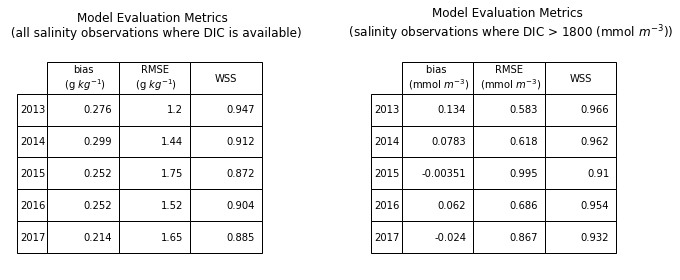

In [40]:
fig = plt.figure()
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
fs = 10
sc1 = 2.5
sc2 = 2.5
y = [1, 2, 3, 4, 5, 4, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1]    
col_labels = ['bias\n (g $kg^{-1}$)', 'RMSE\n (g $kg^{-1}$)', 'WSS']
row_labels = ['2013', '2014', '2015','2016','2017']
table_vals = [[11, 12, 13], [21, 22, 23], [31, 32, 33],[21, 22, 23],[21, 22, 23]]



# Draw table
the_table = plt.table(cellText=tablelist,
                      colWidths=[0.1] * 3,
                      rowLabels=row_labels,
                      colLabels=col_labels,
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(fs)
the_table.scale(sc1, sc2)

# Removing ticks and spines enables you to get the figure only with table
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
    
plt.title('Model Evaluation Metrics \n (all salinity observations where DIC is available)')
    
ax = fig.add_subplot(122)
y = [1, 2, 3, 4, 5, 4, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1]    
col_labels = ['bias \n (mmol $m^{-3}$)', 'RMSE\n (mmol $m^{-3}$)', 'WSS']
row_labels = ['2013', '2014', '2015','2016','2017']
table_vals = [[11, 12, 13], [21, 22, 23], [31, 32, 33],[21, 22, 23],[21, 22, 23]]

# Draw table
the_table = plt.table(cellText=tablelist_over1800,
                      colWidths=[0.1] * 3,
                      rowLabels=row_labels,
                      colLabels=col_labels,
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(fs)
the_table.scale(sc1, sc2)
plt.title('Model Evaluation Metrics \n (salinity observations where DIC > 1800 (mmol $m^{-3}$))')
# Removing ticks and spines enables you to get the figure only with table
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)

plt.tight_layout()

In [39]:
print('Mean bias: '+str(np.mean(sal_bias)))
print('Mean RMSE: '+str(np.mean(sal_RMSE)))
print('Mean WSS: '+str(np.mean(sal_WSS)))
print()
print('Mean bias over 1800: '+str(np.mean(sal_bias_over1800)))
print('Mean RMSE over 1800: '+str(np.mean(sal_RMSE_over1800)))
print('Mean WSS over 1800: '+str(np.mean(sal_WSS_over1800)))

Mean bias: 0.25853295046292357
Mean RMSE: 1.512697162658495
Mean WSS: 0.9040016546330811

Mean bias over 1800: 0.0494656800774159
Mean RMSE over 1800: 0.7496887030124445
Mean WSS over 1800: 0.9447377146258598
